In [1]:
from IPython.display import clear_output
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # for saving videos
    !apt-get install ffmpeg

    !pip install gymnasium   # conferir se precisa

    # clone repository
    !git clone https://github.com/LucaLemos/UFRPE_AprendizagemReforco
    sys.path.append("/content/UFRPE_AprendizagemReforco")

    clear_output()
else:
    from os import path
    sys.path.append( path.dirname( path.dirname( path.abspath("__main__") ) ) )


In [2]:
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

from util.qtable_helper import record_video_qtable, evaluate_qtable_policy
from util.notebook import display_videos_from_path


In [3]:
# Configuração do ambiente
ENV_NAME = "Taxi-v3"
env = gym.make(ENV_NAME, render_mode="rgb_array")

In [4]:
# Hiperparâmetros
GAMMA = 0.95  # Fator de desconto
ITERATIONS = 500  # Número de iterações do Fitted Q-Iteration
BATCH_SIZE = 128  # Tamanho do batch para treinamento da rede neural
LEARNING_RATE = 1e-3  # Taxa de aprendizado para o otimizador

In [5]:
# Passo 1: Definir a Rede Neural para Aproximação da Função Q
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)  # Camada fully connected 1
        self.fc2 = nn.Linear(64, 64)         # Camada fully connected 2
        self.fc3 = nn.Linear(64, output_dim) # Camada de saída

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Função de ativação ReLU
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Inicializar a rede neural
input_dim = env.observation_space.n  # Número de estados
output_dim = env.action_space.n      # Número de ações
q_network = QNetwork(input_dim, output_dim)
optimizer = optim.Adam(q_network.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()  # Função de perda: Erro Quadrático Médio

# Função para converter estados em tensores one-hot
def to_one_hot(state, num_states):
    one_hot = np.zeros(num_states)
    one_hot[state] = 1
    return torch.FloatTensor(one_hot)

In [6]:
# Carregar o replay buffer salvo
replay_buffer = np.load('dataSet/greedyDataSetTaxi.npy', allow_pickle=True)
print("Replay buffer carregado com sucesso! Tamanho:", len(replay_buffer))

Replay buffer carregado com sucesso! Tamanho: 20000


In [7]:
# Passo 2: Definir a função evaluate_policy e extract_policy
def evaluate_policy(env, policy, episodes=100):
    total_rewards = []
    for _ in range(episodes):
        state, _ = env.reset()
        done = False
        episode_reward = 0
        while not done:
            action = policy[state]  # Segue a política aprendida
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            state = next_state
        total_rewards.append(episode_reward)
    return np.mean(total_rewards)

def extract_policy(q_network, num_states):
    policy = []
    for state in range(num_states):
        state_tensor = to_one_hot(state, num_states).unsqueeze(0)
        q_values = q_network(state_tensor)
        policy.append(torch.argmax(q_values).item())
    return policy

In [8]:
# Passo 3: Aplicar Fitted Q-Iteration (Offline RL)
# Listas para armazenar métricas
losses = []
success_rates = []
q_values_means = []
rewards_variances = []

for iteration in range(ITERATIONS):
    # Amostrar um batch de transições do replay buffer
    batch = random.sample(list(replay_buffer), BATCH_SIZE)
    states, actions, rewards, next_states, dones = zip(*batch)

    # Converter estados e próximos estados para one-hot
    states = torch.stack([to_one_hot(s, input_dim) for s in states])
    next_states = torch.stack([to_one_hot(ns, input_dim) for ns in next_states])
    actions = torch.LongTensor(actions)
    rewards = torch.FloatTensor(rewards)
    dones = torch.FloatTensor(dones)

    # Calcular os valores Q atuais
    current_q_values = q_network(states).gather(1, actions.unsqueeze(1)).squeeze()

    # Calcular os valores Q alvo (target)
    with torch.no_grad():
        next_q_values = q_network(next_states).max(1)[0]
        target_q_values = rewards + GAMMA * next_q_values * (1 - dones)

    # Calcular a perda e atualizar a rede
    loss = criterion(current_q_values, target_q_values)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Métricas adicionais
    q_values_means.append(current_q_values.mean().item())  # Valor Q médio
    rewards_variances.append(torch.var(rewards).item())   # Variância das recompensas

    # Avaliação periódica da política
    if iteration % 25 == 0:  # Avaliar a cada 25 iterações
        success_rate = evaluate_policy(env, extract_policy(q_network, input_dim), episodes=500)  # 500 episódios
        losses.append(loss.item())
        success_rates.append(success_rate)
        print(f"Iteração {iteration}, Perda: {loss.item():.4f}, Taxa de Sucesso: {success_rate:.2f}%")

Iteração 0, Perda: 0.7244, Taxa de Sucesso: -200.00%
Iteração 25, Perda: 1.2552, Taxa de Sucesso: -200.00%
Iteração 50, Perda: 0.0641, Taxa de Sucesso: -785.29%
Iteração 75, Perda: 0.0027, Taxa de Sucesso: -1952.98%
Iteração 100, Perda: 0.0014, Taxa de Sucesso: -214.38%
Iteração 125, Perda: 0.0065, Taxa de Sucesso: -200.00%
Iteração 150, Perda: 0.0592, Taxa de Sucesso: -200.00%
Iteração 175, Perda: 0.0380, Taxa de Sucesso: -200.00%
Iteração 200, Perda: 1.3057, Taxa de Sucesso: -200.00%
Iteração 225, Perda: 0.0033, Taxa de Sucesso: -200.00%
Iteração 250, Perda: 0.5159, Taxa de Sucesso: -200.00%
Iteração 275, Perda: 0.0016, Taxa de Sucesso: -200.00%
Iteração 300, Perda: 0.2345, Taxa de Sucesso: -200.00%
Iteração 325, Perda: 0.0012, Taxa de Sucesso: -200.00%
Iteração 350, Perda: 0.2654, Taxa de Sucesso: -200.00%
Iteração 375, Perda: 0.2690, Taxa de Sucesso: -200.00%
Iteração 400, Perda: 0.0033, Taxa de Sucesso: -200.00%
Iteração 425, Perda: 0.0076, Taxa de Sucesso: -200.00%
Iteração 450, 

In [9]:
# Passo 4: Avaliar a Política Aprendida
optimal_policy = extract_policy(q_network, input_dim)

success_rate = evaluate_policy(env, optimal_policy, episodes=500)  # 500 episódios
print(f"Taxa de sucesso da política aprendida: {success_rate:.2f}%")

Taxa de sucesso da política aprendida: -200.00%


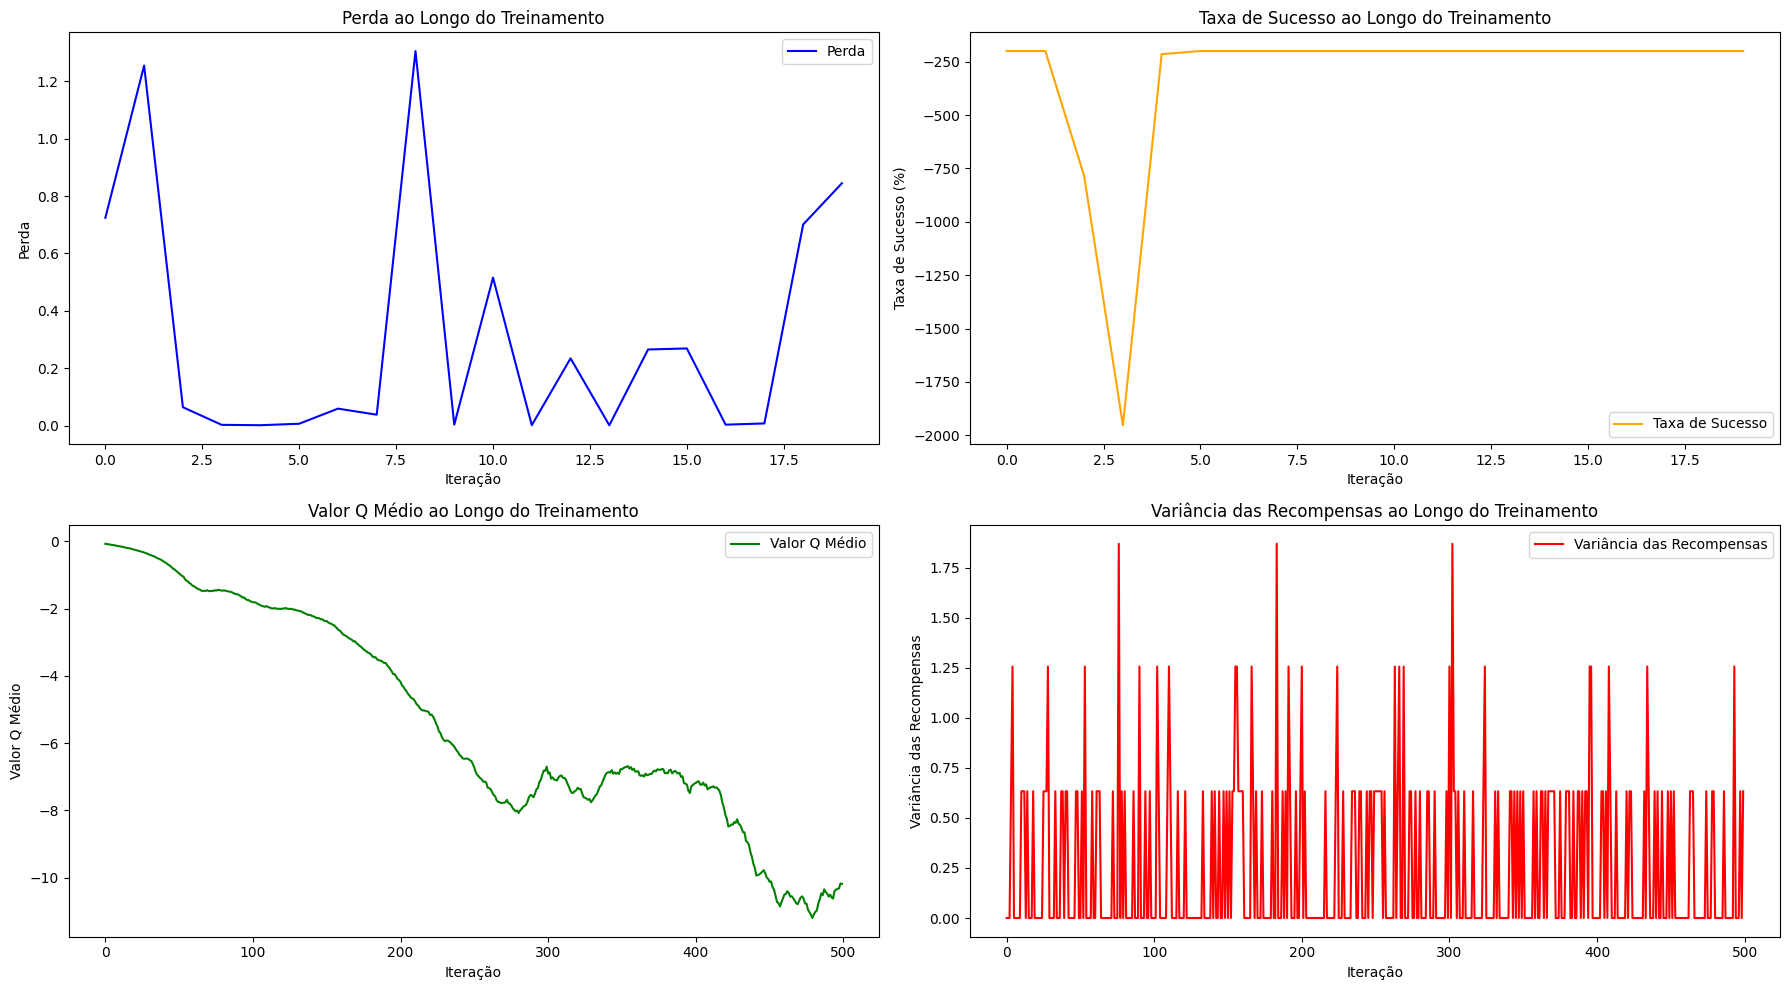

In [10]:
# Passo 5: Visualização Gráfica
plt.figure(figsize=(18, 10))

# Gráfico da Perda
plt.subplot(2, 2, 1)
plt.plot(losses, label="Perda", color="blue")
plt.xlabel("Iteração")
plt.ylabel("Perda")
plt.title("Perda ao Longo do Treinamento")
plt.legend()

# Gráfico da Taxa de Sucesso
plt.subplot(2, 2, 2)
plt.plot(success_rates, label="Taxa de Sucesso", color="orange")
plt.xlabel("Iteração")
plt.ylabel("Taxa de Sucesso (%)")
plt.title("Taxa de Sucesso ao Longo do Treinamento")
plt.legend()

# Gráfico do Valor Q Médio
plt.subplot(2, 2, 3)
plt.plot(q_values_means, label="Valor Q Médio", color="green")
plt.xlabel("Iteração")
plt.ylabel("Valor Q Médio")
plt.title("Valor Q Médio ao Longo do Treinamento")
plt.legend()

# Gráfico da Variância das Recompensas
plt.subplot(2, 2, 4)
plt.plot(rewards_variances, label="Variância das Recompensas", color="red")
plt.xlabel("Iteração")
plt.ylabel("Variância das Recompensas")
plt.title("Variância das Recompensas ao Longo do Treinamento")
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
# Passo 6: Implementar Q-Iteration (Programação Dinâmica)
def q_iteration(env, gamma=GAMMA, iterations=1000):
    num_states = env.observation_space.n
    num_actions = env.action_space.n
    Q = np.zeros((num_states, num_actions))  # Tabela Q inicializada com zeros

    for _ in range(iterations):
        Q_prev = Q.copy()
        for state in range(num_states):
            for action in range(num_actions):
                # Pega todas as transições possíveis para o par (state, action)
                transitions = env.unwrapped.P[state][action]
                q_value = 0
                for prob, next_state, reward, done in transitions:
                    # Atualiza o valor Q usando a equação de Bellman
                    q_value += prob * (reward + gamma * np.max(Q_prev[next_state]))
                Q[state][action] = q_value

        # Verifica convergência
        if np.max(np.abs(Q - Q_prev)) < 1e-6:
            break

    return Q

In [12]:
# Executar Q-Iteration
Q_table = q_iteration(env)
print("Tabela Q ótima calculada por Q-Iteration:")
print(Q_table)

# Extrair política ótima da tabela Q
optimal_policy_q_iteration = np.argmax(Q_table, axis=1)
print("\nPolítica ótima calculada por Q-Iteration:")
print(optimal_policy_q_iteration)

# Avaliar a política ótima do Q-Iteration
success_rate_q_iteration = evaluate_policy(env, optimal_policy_q_iteration) * 100
print(f"\nTaxa de sucesso da política aprendida por Q-Iteration: {success_rate_q_iteration:.2f}%")

Tabela Q ótima calculada por Q-Iteration:
[[164.66537545 174.38460673 164.66537545 174.38460673 184.61537545
  165.38460673]
 [102.51077994 108.95871672 102.51077994 108.95871672 115.74601755
   99.95871672]
 [130.41110077 138.32747548 130.41110077 138.32747548 146.66050045
  129.32747548]
 ...
 [146.66050045 155.43210673 146.66050045 138.32747548 137.66050045
  137.66050045]
 [115.74601755 122.89054578 115.74601755 122.89054578 106.74601755
  106.74601755]
 [174.38460673 164.66537545 174.38460673 184.61537545 165.38460673
  165.38460673]]

Política ótima calculada por Q-Iteration:
[4 4 4 4 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 3
 0 0 0 0 0 0 0 2 2 2 2 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 2 2 2 0 0 0 0 0 0
 0 0 0 2 0 0 0 0 0 0 4 4 4 4 0 0 0 0 0 0 0 0 0 5 0 0 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1

In [13]:
# Gravar um vídeo da política treinada
record_video_qtable(ENV_NAME, Q_table, episodes=2, folder='videos/', prefix='q-iteration')

display_videos_from_path('videos/', prefix='q-iteration')

C:\Users\lucam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at d:\Downloads_D\Faculdade\git\videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
